In [2]:
import sys
import os

# Add the current working directory to sys.path
sys.path.append(os.path.abspath('..'))

# Print sys.path to verify the change
print(sys.path)



['/home/lpr/project_nattabude/carla/self-driving-sb3/notebook', '/home/lpr', '/home/lpr/miniconda3/envs/TRT86/lib/python38.zip', '/home/lpr/miniconda3/envs/TRT86/lib/python3.8', '/home/lpr/miniconda3/envs/TRT86/lib/python3.8/lib-dynload', '', '/home/lpr/miniconda3/envs/TRT86/lib/python3.8/site-packages', '/home/lpr/project_nattabude/carla/self-driving-sb3']


In [2]:
import matplotlib.pyplot as plt
from segmentation.seg_hf import HF_mask2Formermodel
import cv2
from torchvision import transforms
import numpy as np
from PIL import Image
import torch

/home/lpr/miniconda3/envs/TRT86/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

modelrepo = "facebook/mask2former-swin-large-mapillary-vistas-semantic"
seg_model = HF_mask2Formermodel(modelrepo,fp16=True)

using  cuda
inference time :0.052466


In [4]:

img1 = cv2.cvtColor(cv2.imread("../data/raw_4cams/front/1820.jpg"),cv2.COLOR_BGR2RGB)


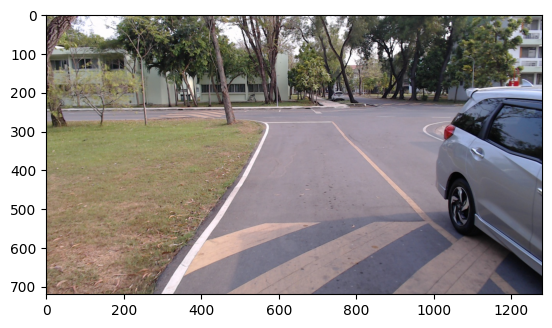

In [5]:
plt.imshow(img1)

(<matplotlib.image.AxesImage at 0x780d6022bbe0>, (512, 1024, 3))

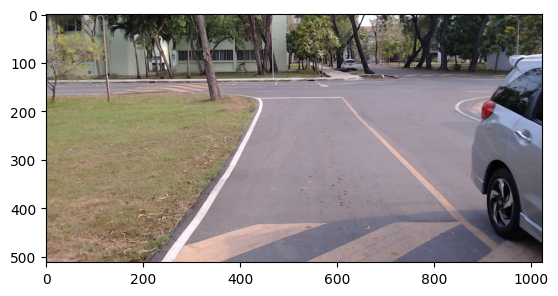

In [6]:
input_image = img1[104:616,128:1152]
plt.imshow(input_image),input_image.shape

In [7]:
mapping = {13:1,7:1,23:2,24:2,52:3,55:3,57:3,20:4,21:4,22:4,19:4} # 0 is back ground
seg_model.apply_label_mapping(mapping)

In [8]:

seg_map=seg_model([input_image])[0][0]
seg_map.shape

(512, 1024)

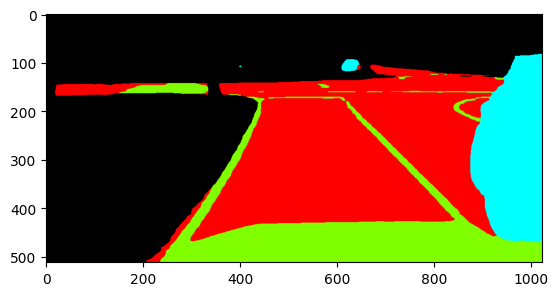

In [9]:
plt.imshow(seg_model.get_seg_images([seg_map])[0])

In [10]:
seg_map,seg_map.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2]], dtype=uint8),
 (512, 1024))

In [11]:
np.unique(seg_map)

array([0, 1, 2, 3], dtype=uint8)

preprocess

In [10]:
test_transforms = transforms.Compose([
                                    transforms.Resize((245, 245)),
                                        # transforms.Grayscale(), 
                                        transforms.ToTensor(),                           
                        transforms.Lambda(lambda x: ((x * 255.0) / 4.0))
                        ])

In [45]:
pil_map = Image.fromarray(seg_map)

In [15]:
pil_map.size

(1024, 512)

In [46]:
tran_segmap = test_transforms(pil_map)

In [47]:
tran_segmap[0].unique()

tensor([0.0000, 0.2500, 0.5000, 0.7500])

In [13]:
from torch.nn import functional as F

In [42]:
tran_segmap2= (torch.tensor(seg_map)/4).unsqueeze(0).unsqueeze(0)

In [43]:
tran_segmap2 = F.interpolate(tran_segmap2, size=(245, 245), mode='bilinear', align_corners=False)

In [ ]:
tran_segmap2.unique()

In [18]:
torch.equal(tran_segmap.unsqueeze(0),tran_segmap2)

False

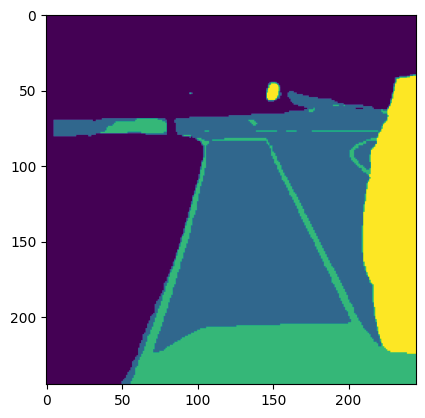

In [48]:
plt.imshow(tran_segmap[0])

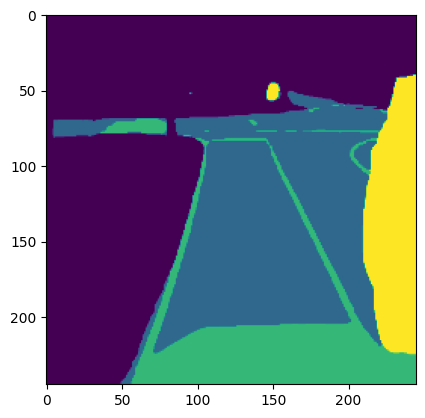

In [37]:
plt.imshow(tran_segmap2[0][0])

## vae 

### test vae

In [14]:
from autoencoder.CNNVae import VariationalAutoencoder,Encoder

vae_path = "../autoencoder/model/vae32/best"
vae = VariationalAutoencoder(latent_dims=32)
encoder = Encoder(latent_dims=32)
vae.load(vae_path)
encoder.load(os.path.join(vae_path,"var_encoder_model.pth"))


using:  cuda
loaded from ../autoencoder/model/vae32/best


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:


with torch.no_grad(): # No need to track the gradients

    # Move tensor to the proper device
    x = tran_segmap.unsqueeze(0)
    # Decode data
    x_hat = vae(x)
    x_hat = x_hat.cpu()
    x_hat = x_hat.squeeze(0)

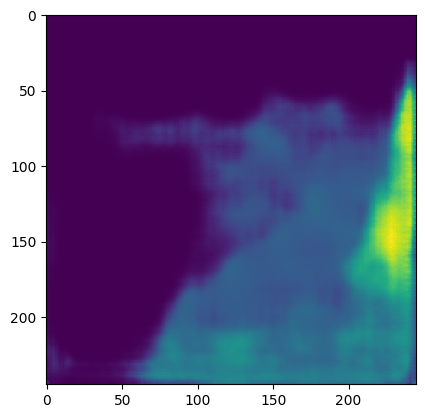

In [84]:
plt.imshow(x_hat.squeeze(0))

In [ ]:
encoder.to(device)

In [44]:
seg_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=uint8)

In [89]:
with torch.no_grad(): # No need to track the gradients

    # Move tensor to the proper device
    x = tran_segmap.unsqueeze(0)
    # Decode data
    latents = encoder(x)

/home/lpr/TensorRT-8.6.1.6/lib  /home/lpr/TensorRT-8.6.1.6/python/tensorrt-8.6.1-cp38-none-linux_x86_64.whl /home/lpr/TensorRT-8.6.1.6/onnx_graphsurgeon/onnx_graphsurgeon-0.3.12-py2.py3-none-any.whl

In [91]:
latents.shape

torch.Size([1, 32])

In [ ]:
pil_map

In [23]:
dummy_images = np.random.randint(0, 4, (512,1024), dtype=np.uint8)

### wrapper

In [12]:
from autoencoder.vae_wrapper import VencoderWrapper

real_encoder = VencoderWrapper(model_path="../autoencoder/model/vae32/best/var_encoder_model.pth",latent_dims=32)

using cuda
inference time :0.002255


In [14]:
latent = real_encoder(seg_map)
latent,latent.shape

(tensor([[ 0.5030, -1.0611,  1.5007, -2.1452,  0.3737, -0.1847, -1.0322, -1.7938,
          -1.4772,  1.4584,  0.7880, -0.3471,  0.3869,  2.9216, -0.3936, -0.3893,
          -3.0566, -0.6799,  0.1473, -0.1356,  0.9416,  0.7661, -2.0072,  1.3018,
          -1.1174, -1.4872,  0.5584, -1.1243, -1.1588,  0.7935, -0.0197, -1.2020]],
        device='cuda:0'),
 torch.Size([1, 32]))

In [15]:
from autoencoder.vae_wrapper import decoderWrapper
decoder = decoderWrapper(model_path="../autoencoder/model/vae32/best/decoder_model.pth",latent_dims=32)

using cuda
inference time :0.000147


In [17]:
output = decoder(latent).cpu()

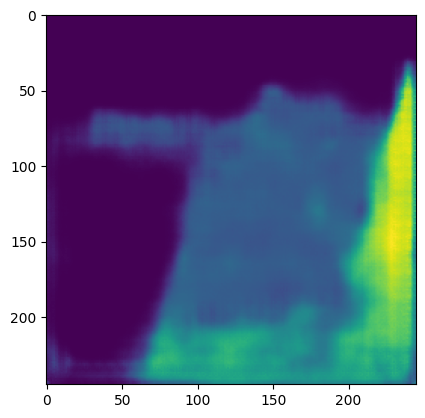

In [20]:
plt.imshow(output[0][0])

## obnserver module

In [1]:
import sys
import os

# Add the current working directory to sys.path
sys.path.append(os.path.abspath('..'))

# Print sys.path to verify the change
print(sys.path)


['/home/lpr/project_nattabude/carla/self-driving-sb3/notebook', '/home/lpr', '/home/lpr/miniconda3/envs/TRT86/lib/python38.zip', '/home/lpr/miniconda3/envs/TRT86/lib/python3.8', '/home/lpr/miniconda3/envs/TRT86/lib/python3.8/lib-dynload', '', '/home/lpr/miniconda3/envs/TRT86/lib/python3.8/site-packages', '/home/lpr/project_nattabude/carla/self-driving-sb3']


In [2]:
# initial segmodel and encoder
from segmentation.seg_hf import HF_mask2Formermodel

modelrepo = "facebook/mask2former-swin-large-mapillary-vistas-semantic"
seg_model = HF_mask2Formermodel(modelrepo,fp16=True)
mapping = {13:1,7:1,23:2,24:2,52:3,55:3,57:3,20:4,21:4,22:4,19:4} # 0 is back ground
seg_model.apply_label_mapping(mapping)

from autoencoder.vae_wrapper import VencoderWrapper
vae_encoder = VencoderWrapper(model_path="../autoencoder/model/vae32/best/var_encoder_model.pth",latent_dims=32)

/home/lpr/miniconda3/envs/TRT86/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using  cuda
inference time :0.051198
using cuda
inference time :0.002430


In [3]:
from environment.tools.observer import SegVaeActHistObserver

observer = SegVaeActHistObserver(vae_encoder = vae_encoder,seg_model=seg_model,latent_space=32,hist_len = 8,skip_frame=0)


In [4]:
import cv2 
from PIL import Image
img1 = cv2.cvtColor(cv2.imread("../data/raw_4cams/front_checked/1810.jpg"),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("../data/raw_4cams/front_checked/1810.jpg"),cv2.COLOR_BGR2RGB)

In [13]:
pred_segs = seg_model([img1,img2])
latents = vae_encoder(pred_segs)


In [12]:
observer.reset([img1])

array([-0.69793898, -0.72082996, -0.05082721, -1.56682491, -1.2393229 ,
        0.71617311,  0.18018033,  0.71966505, -0.29122347,  0.39278805,
       -1.09416497, -1.60873842,  1.21923327,  0.97871125,  0.43901658,
       -0.3148081 , -0.82687157,  0.07503285,  0.95689875,  0.09119222,
       -0.49188748, -0.21703504, -0.94988573, -1.18111312, -1.07271397,
        0.05914178, -0.3908222 , -0.36342698, -1.2037878 , -0.88088739,
       -0.79767627, -0.09642705,  0.        ,  0.        , -0.69793898,
       -0.72082996, -0.05082721, -1.56682491, -1.2393229 ,  0.71617311,
        0.18018033,  0.71966505, -0.29122347,  0.39278805, -1.09416497,
       -1.60873842,  1.21923327,  0.97871125,  0.43901658, -0.3148081 ,
       -0.82687157,  0.07503285,  0.95689875,  0.09119222, -0.49188748,
       -0.21703504, -0.94988573, -1.18111312, -1.07271397,  0.05914178,
       -0.3908222 , -0.36342698, -1.2037878 , -0.88088739, -0.79767627,
       -0.09642705,  0.        ,  0.        , -0.69793898, -0.72

In [13]:
observer.get_state().shape

(272,)

In [18]:
import time
st = time.time()
observer.step(img=[img2],act=[0.3,0.4])
print(f"inference time{time.time()-st:.6f}")

inference time0.070554


In [19]:
observer.get_state(),observer.get_state().shape[0]

(array([-0.69793898, -0.72082996, -0.05082721, -1.56682491, -1.2393229 ,
         0.71617311,  0.18018033,  0.71966505, -0.29122347,  0.39278805,
        -1.09416497, -1.60873842,  1.21923327,  0.97871125,  0.43901658,
        -0.3148081 , -0.82687157,  0.07503285,  0.95689875,  0.09119222,
        -0.49188748, -0.21703504, -0.94988573, -1.18111312, -1.07271397,
         0.05914178, -0.3908222 , -0.36342698, -1.2037878 , -0.88088739,
        -0.79767627, -0.09642705,  0.        ,  0.        , -0.69793898,
        -0.72082996, -0.05082721, -1.56682491, -1.2393229 ,  0.71617311,
         0.18018033,  0.71966505, -0.29122347,  0.39278805, -1.09416497,
        -1.60873842,  1.21923327,  0.97871125,  0.43901658, -0.3148081 ,
        -0.82687157,  0.07503285,  0.95689875,  0.09119222, -0.49188748,
        -0.21703504, -0.94988573, -1.18111312, -1.07271397,  0.05914178,
        -0.3908222 , -0.36342698, -1.2037878 , -0.88088739, -0.79767627,
        -0.09642705,  0.        ,  0.        , -0.6

In [20]:
observer.gym_obs()

Box(-3.4028235e+38, 3.4028235e+38, (1, 272), float32)

In [24]:
import numpy as np
np.concatenate((latents.flatten().cpu().numpy(),[0,0]),axis=-1)

array([-0.68321776, -0.74475169,  0.14595431, -1.68133593, -0.80162066,
        0.54244614,  0.35646456,  0.75302726, -0.43422103, -0.10265526,
       -1.04191983, -1.76768303,  0.85513699,  0.95147794,  0.66078573,
       -0.39200196, -0.73518157, -0.01920085,  0.73857635,  0.45205662,
       -0.91663998, -0.04002233, -0.84360123, -1.23110926, -0.99877703,
        0.50285852,  0.03992254, -0.49807131, -1.0837512 , -1.02214921,
       -0.69698203, -0.17919391, -0.89077759, -0.80476034,  0.00287724,
       -1.516909  , -0.58131182,  0.68989182,  0.30271444,  0.78544319,
       -0.26557365,  0.29493335, -1.25264001, -1.80743957,  0.90137982,
        1.04738641,  0.55788898, -0.3309277 , -0.75837475, -0.03574865,
        0.75151801,  0.37116823, -0.34567195, -0.25410011, -0.811575  ,
       -1.01808023, -1.05480278, -0.0511618 ,  0.02764781, -0.33229178,
       -1.0591346 , -0.98730135, -0.7810756 , -0.18233821,  0.        ,
        0.        ])

In [15]:
import torch
cat_latent = torch.cat(latents, dim=1).cpu()

TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)
